<a href="https://colab.research.google.com/github/drpetros11111/NLP_Portilia/blob/main/02_Text_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

___

<a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
___

# Text Classification Project
Now we're at the point where we should be able to:
* Read in a collection of documents - a *corpus*
* Transform text into numerical vector data using a pipeline
* Create a classifier
* Fit/train the classifier
* Test the classifier on new data
* Evaluate performance

For this project we'll use the Cornell University Movie Review polarity dataset v2.0 obtained from http://www.cs.cornell.edu/people/pabo/movie-review-data/

In this exercise we'll try to develop a classification model as we did for the SMSSpamCollection dataset - that is, we'll try to predict the Positive/Negative labels based on text content alone. In an upcoming section we'll apply *Sentiment Analysis* to train models that have a deeper understanding of each review.

## Perform imports and load the dataset
The dataset contains the text of 2000 movie reviews. 1000 are positive, 1000 are negative, and the text has been preprocessed as a tab-delimited file.

In [12]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/moviereviews.tsv', sep='\t')
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


In [13]:
len(df)

2000

### Take a look at a typical review. This one is labeled "negative":

In [14]:
from IPython.display import Markdown, display
display(Markdown('> '+df['review'][0]))

> how do films like mouse hunt get into theatres ? 
isn't there a law or something ? 
this diabolical load of claptrap from steven speilberg's dreamworks studio is hollywood family fare at its deadly worst . 
mouse hunt takes the bare threads of a plot and tries to prop it up with overacting and flat-out stupid slapstick that makes comedies like jingle all the way look decent by comparison . 
writer adam rifkin and director gore verbinski are the names chiefly responsible for this swill . 
the plot , for what its worth , concerns two brothers ( nathan lane and an appalling lee evens ) who inherit a poorly run string factory and a seemingly worthless house from their eccentric father . 
deciding to check out the long-abandoned house , they soon learn that it's worth a fortune and set about selling it in auction to the highest bidder . 
but battling them at every turn is a very smart mouse , happy with his run-down little abode and wanting it to stay that way . 
the story alternates between unfunny scenes of the brothers bickering over what to do with their inheritance and endless action sequences as the two take on their increasingly determined furry foe . 
whatever promise the film starts with soon deteriorates into boring dialogue , terrible overacting , and increasingly uninspired slapstick that becomes all sound and fury , signifying nothing . 
the script becomes so unspeakably bad that the best line poor lee evens can utter after another run in with the rodent is : " i hate that mouse " . 
oh cringe ! 
this is home alone all over again , and ten times worse . 
one touching scene early on is worth mentioning . 
we follow the mouse through a maze of walls and pipes until he arrives at his makeshift abode somewhere in a wall . 
he jumps into a tiny bed , pulls up a makeshift sheet and snuggles up to sleep , seemingly happy and just wanting to be left alone . 
it's a magical little moment in an otherwise soulless film . 
a message to speilberg : if you want dreamworks to be associated with some kind of artistic credibility , then either give all concerned in mouse hunt a swift kick up the arse or hire yourself some decent writers and directors . 
this kind of rubbish will just not do at all . 


# Import Libraries

    from IPython.display import Markdown, display

This imports two functions from the IPython.display module:
Markdown:

--------------------------------------
#Markdown

This function is used to render text in Markdown format within a Jupyter notebook.

-----------------
#display

This function is used to display the given content (text, HTML, Markdown, etc.) in the notebook's output cells.
display(Markdown('> '+df['review'][0])):

##df['review'][0]:

This part assumes that df is a pandas DataFrame, and it is accessing the first entry in the review column (index 0).

##'>' + df['review'][0]:
The > symbol in Markdown is used to create a blockquote.

This expression concatenates the > symbol with the first review (the text from df['review'][0]), so that the review text will be rendered as a blockquote in the notebook.

##Markdown(...):
This wraps the review text in Markdown format, meaning it will be displayed as Markdown in the notebook.

#display(...):
Finally, the display function is used to render the Markdown-formatted text in the notebook's output.

-------------------------
#Summary
This code takes the first review from the review column of the DataFrame df, formats it as a Markdown blockquote (with the > symbol), and displays it nicely within a Jupyter notebook.

For example, if df['review'][0] contains "This is a great product!", the code would display the following blockquote in the notebook:

> This is a great product!

## Check for missing values:
We have intentionally included records with missing data. Some have NaN values, others have short strings composed of only spaces. This might happen if a reviewer declined to provide a comment with their review. We will show two ways using pandas to identify and remove records containing empty data.
* NaN records are efficiently handled with [.isnull()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isnull.html) and [.dropna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html)
* Strings that contain only whitespace can be handled with [.isspace()](https://docs.python.org/3/library/stdtypes.html#str.isspace), [.itertuples()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.itertuples.html), and [.drop()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html)

### Detect & remove NaN values:

In [15]:
len(df)

2000

In [16]:
# Check for the existence of NaN values in a cell:
df.isnull().sum()


,0
label,0
review,35


35 records show **NaN** (this stands for "not a number" and is equivalent to *None*). These are easily removed using the `.dropna()` pandas function.
<div class="alert alert-info" style="margin: 20px">CAUTION: By setting inplace=True, we permanently affect the DataFrame currently in memory, and this can't be undone. However, it does *not* affect the original source data. If we needed to, we could always load the original DataFrame from scratch.</div>

In [17]:
df.dropna(inplace=True)

len(df)

1965

### Detect & remove empty strings
Technically, we're dealing with "whitespace only" strings. If the original .tsv file had contained empty strings, pandas **.read_csv()** would have assigned NaN values to those cells by default.

In order to detect these strings we need to iterate over each row in the DataFrame. The **.itertuples()** pandas method is a good tool for this as it provides access to every field. For brevity we'll assign the names `i`, `lb` and `rv` to the `index`, `label` and `review` columns.

In [18]:
blanks = []  # start with an empty list

for i,lb,rv in df.itertuples():  # iterate over the DataFrame
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list

print(len(blanks), 'blanks: ', blanks)

27 blanks:  [57, 71, 147, 151, 283, 307, 313, 323, 343, 351, 427, 501, 633, 675, 815, 851, 977, 1079, 1299, 1455, 1493, 1525, 1531, 1763, 1851, 1905, 1993]


# Identify empty strings (white-space only) in the review column
The code you shared is designed to identify rows in a pandas DataFrame (df) where the values in the review column consist only of whitespace (or are empty strings).

It adds the index of these rows to a list called blanks. Let's break it down step by step:

-------------------------------
    blanks = []

This initializes an empty list called blanks which will store the indices of rows that have reviews consisting only of whitespace.

    for i, lb, rv in df.itertuples():

This line uses itertuples() to iterate over the rows of the DataFrame (df). itertuples() generates named tuples for each row of the DataFrame, and each tuple contains the index and column values.

    i

represents the index of the row.

    lb

represents the value of the first column after the index (presumably the label column in this case).

    rv

represents the value from the review column.

    if type(rv)==str:

This checks if the value in the review column (rv) is a string.

This ensures that the code avoids NaN values (which can be of type float, not str).

    if rv.isspace():

This checks if the string in the review column consists only of whitespace characters (spaces, tabs, newlines, etc.).

The
    .isspace()

method returns True if all characters in the string are whitespace, and False otherwise.

    blanks.append(i)

If the rv (review) is indeed a string containing only whitespace, the index i is appended to the blanks list.

    print(len(blanks), 'blanks: ', blanks)

After the loop finishes, this prints the number of rows with blank reviews (len(blanks)), followed by the actual list of indices where these blank reviews were found.

-------------------------------
#Example Behavior
Suppose you have a DataFrame (df) like this:

index	label	review
    0	pos	"Great product!"
    1	neg	" "
    2	pos	""
    3	neg	"Not worth it."
    4	pos	" "

Row 1 and 4 contain only whitespace.

The code would append indices 1 and 4 to blanks, and then print something like:

    2 blanks:  [1, 4]

----------------------------
#Summary
This code looks for rows in the DataFrame where the review column contains only whitespace.

It collects the indices of those rows and prints both the number of such rows and their indices.

# Note -itertuples()
itertuples() is a method provided by pandas that allows you to iterate over rows of a DataFrame as named tuples.

Each tuple corresponds to a row in the DataFrame, with its fields representing the values of the row's columns.

It is a very efficient way to loop over the DataFrame rows compared to using .iterrows() because itertuples() avoids the overhead of constructing a pandas Series for each row.

-------------------------------
##Key Points:
###Named Tuples:
Each row is returned as a namedtuple, where each field corresponds to a column in the DataFrame.

You can access the values either by index or by the column name as an attribute of the tuple.

###Efficient:
itertuples() is generally faster than iterrows() because it doesn’t convert each row to a Series object.

Instead, it directly returns a tuple, which is more lightweight.

-------------------------
#Example
Let's consider a simple DataFrame:

    import pandas as pd

    data = {'label': ['pos', 'neg', 'pos'],
        'review': ['Great product!', 'Not good', 'Excellent!']}
        
    df = pd.DataFrame(data)

# Using itertuples
    for row in df.itertuples():
       print(row)

#Output:

    Pandas(Index=0, label='pos', review='Great product!')
    Pandas(Index=1, label='neg', review='Not good')
    Pandas(Index=2, label='pos', review='Excellent!')

------------------------------------
Here:

###Index=0, 1, 2 represents the row index.

label and review are the column names, and their values correspond to the row’s data.

###Accessing Values:
You can access the fields of the named tuple like this:

    for row in df.itertuples():
    print(row.label, row.review)

------------------------------------
##Output:

    pos Great product!
    neg Not good
    pos Excellent!

##Customizing Columns:
By default, the first element in the named tuple is the index of the row (like Pandas(Index=0, ...)).

You can disable this behavior using itertuples(index=False) if you don’t want to include the row index in the tuple:

    for row in df.itertuples(index=False):
       print(row)

###Output:

    Pandas(label='pos', review='Great product!')
    Pandas(label='neg', review='Not good')
    Pandas(label='pos', review='Excellent!')

-----------------------------
#Why Use itertuples()?
##Performance:
It is faster than iterrows() because it doesn't convert rows to Series objects.

##Convenience:
Since it returns a named tuple, accessing columns by name is intuitive and avoids using indices.

In conclusion, itertuples() is an efficient, easy-to-use method for iterating over DataFrame rows, especially when you need both speed and readability.

In [19]:
df.drop(blanks, inplace=True)

len(df)

1938

Great! We dropped 62 records from the original 2000. Let's continue with the analysis.

## Take a quick look at the `label` column:

In [20]:
df['label'].value_counts()

,count
label,
neg,969
pos,969


## Split the data into train & test sets:

In [21]:
from sklearn.model_selection import train_test_split

X = df['review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Build pipelines to vectorize the data, then train and fit a model
Now that we have sets to train and test, we'll develop a selection of pipelines, each with a different model.

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Naïve Bayes:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Define a Pipeline
    Pipeline (from sklearn.pipeline)

A Pipeline is a tool provided by scikit-learn to automate workflows that involve multiple steps, such as transforming data and then applying a machine learning algorithm.

In this case, it's used to chain together a text vectorization step (using TfidfVectorizer) and a classification step (using either MultinomialNB or LinearSVC).

----------------------------------------------
    TfidfVectorizer (from sklearn.feature_extraction.text)

#This is the text vectorization step.

It converts raw text into numerical features by calculating TF-IDF (Term Frequency-Inverse Document Frequency) values for each word in the text.

#TF (Term Frequency)

Counts how often a word appears in a document.

----------------------------
#IDF (Inverse Document Frequency)

Reduces the weight of common words that appear in many documents, focusing on words that are more unique to specific documents.

The TfidfVectorizer will take the input text data, tokenize it, and convert it into a matrix of TF-IDF features that can be used by a classifier.

-------------------------------------
#MultinomialNB (from sklearn.naive_bayes)

This is the classifier in the first pipeline. MultinomialNB is a Naive Bayes classifier that works well for text data, particularly for classification problems where the features represent discrete frequency counts (e.g., how often a word appears in a document).

Naive Bayes is a probabilistic classifier based on applying Bayes' theorem, assuming that the features are conditionally independent of each other.

--------------------------
#LinearSVC (from sklearn.svm)

This is the classifier in the second pipeline. LinearSVC is a Support Vector Classifier (SVC) that uses a linear kernel, which works well for high-dimensional datasets like text data.

SVC attempts to find a hyperplane that best separates the classes in the dataset by maximizing the margin between them.
Linear SVC is often faster for text classification problems due to its linear nature and is useful for binary or multi-class classification tasks.

----------------------------------------
#Pipelines Explanation:
#1. Naive Bayes Pipeline (text_clf_nb):

    text_clf_nb = Pipeline([
        ('tfidf', TfidfVectorizer()),   # Step 1: Convert text to TF-IDF vectors
        ('clf', MultinomialNB()),       # Step 2: Apply Naive Bayes classification
      ])
This pipeline first transforms the text using TfidfVectorizer() to generate numerical features from the text data.

Then, it passes these features to MultinomialNB(), the Naive Bayes classifier, which will predict the class labels based on the learned probability distributions.

-----------------------------------------
#2. Linear SVC Pipeline (text_clf_lsvc):

    text_clf_lsvc = Pipeline([
       ('tfidf', TfidfVectorizer()),   # Step 1: Convert text to TF-IDF vectors
      ('clf', LinearSVC()),           # Step 2: Apply Linear Support Vector Classification
       ])

This pipeline is similar to the Naive Bayes pipeline, except that the classifier step uses LinearSVC() instead of Naive Bayes.

After transforming the text with TfidfVectorizer(), the numerical features are passed to the LinearSVC() classifier, which learns a linear decision boundary between the classes.

----------------------------
#Summary
Both pipelines follow the same structure: they convert raw text data into TF-IDF feature vectors and then apply a classifier.

The first pipeline (text_clf_nb) uses the Naive Bayes classifier, which is simple and works well for certain types of text classification tasks, especially when the features (words) are conditionally independent.

The second pipeline (text_clf_lsvc) uses Linear SVC, which is a more powerful model for classification tasks that involve high-dimensional feature spaces, like text data.

Once these pipelines are set up, they can be used to train on labeled text data and make predictions on new, unseen text.

-----------------------------
------------------------------------
#Note 1 - TF-IDF
TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (often called a corpus).

TF-IDF is commonly used in text mining, information retrieval, and natural language processing tasks like document classification and information retrieval, where it's important to weigh words by their relevance rather than just frequency.

-----------------------
#TF-IDF Components:
TF-IDF is a combination of two metrics:

##TF (Term Frequency):

This measures how frequently a word (term) appears in a document.

For a term
𝑡 in a document 𝑑, the term frequency Tf(𝑡, 𝑑)

##TF(t,d) is calculated as:
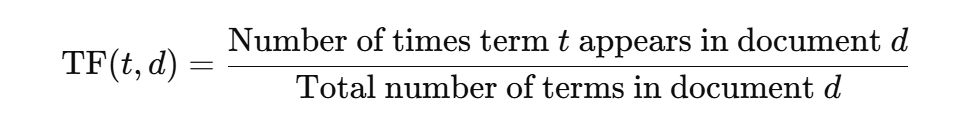


##Example:
If the term "data" appears 3 times in a document with 100 words, the term frequency for "data" is
$$3/100= 0.03$$

---------------------------------
#IDF (Inverse Document Frequency)

This measures how important or rare a term is across the entire collection of documents (the corpus).

If a term appears in many documents, it is less informative (i.e., common words like "the", "is", etc.). Rare words are more informative.

The inverse document frequency is calculated as:
IDF
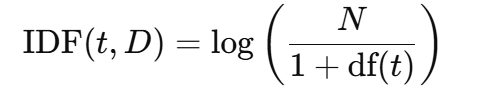

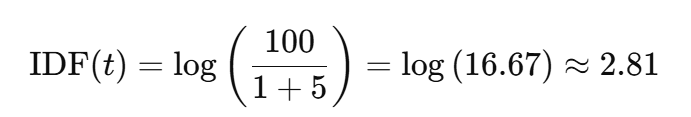

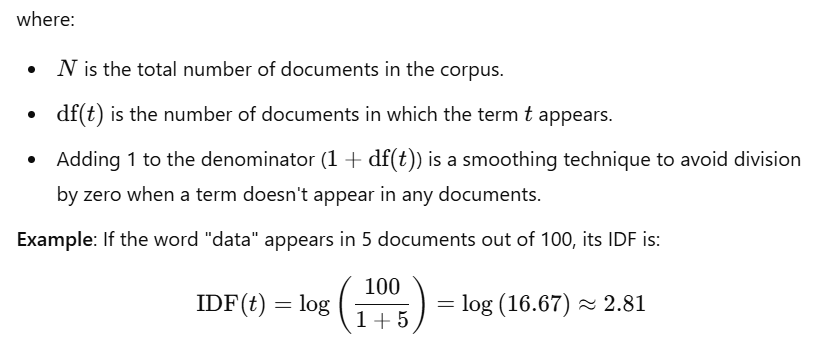

Example:
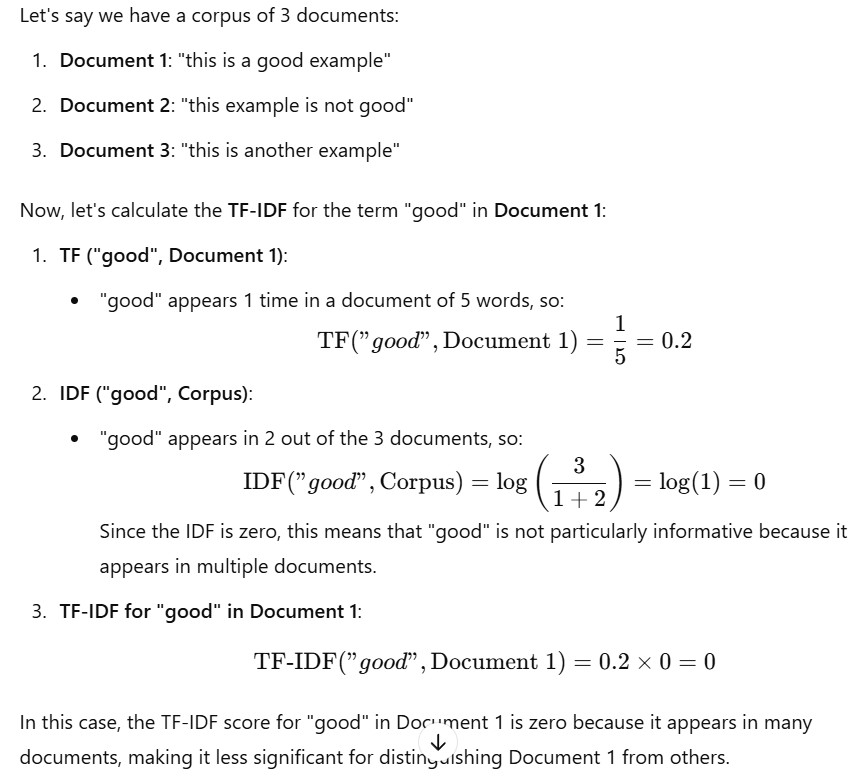

--------------------------------------------
#Example
Let's say we have a corpus of 3 documents:

    Document 1: "this is a good example"
    Document 2: "this example is not good"
    Document 3: "this is another example"

#Key Insights:
##High TF-IDF:
A high TF-IDF score for a term in a document indicates that the term is frequent in that specific document but rare across the whole corpus.

This makes it an important term for that document.

##Low TF-IDF:

A low TF-IDF score means the term is either frequent across many documents (like stop words "the", "is") or it's not frequent in the specific document.

------------------------------------------------------------
#How TF-IDF is Used:
##Text Classification:
By converting text documents into numerical vectors using TF-IDF, classifiers can then work with these vectors to classify documents into different categories (e.g., spam vs. non-spam emails).

##Information Retrieval
TF-IDF can help in search engines to rank documents by relevance to a query. Terms with high TF-IDF scores in the query are given more importance.

#In Scikit-learn:
In Python's scikit-learn, the TfidfVectorizer is used to convert text data into a TF-IDF matrix. Here's an example of how it works:

    from sklearn.feature_extraction.text import TfidfVectorizer

# Sample documents
    docs = ["this is a good example", "this example is not good", "this is another example"]

# Create the TfidfVectorizer
    vectorizer = TfidfVectorizer()

# Fit and transform the documents into a TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(docs)

# Get feature names (terms) and corresponding TF-IDF values
    print(vectorizer.get_feature_names_out())  # ['another', 'example', 'good', 'is', 'not', 'this']
    print(tfidf_matrix.toarray())  # TF-IDF matrix for each document
This converts the text documents into a matrix of TF-IDF features, where each row corresponds to a document and each column corresponds to a term's TF-IDF score.

---------------------------------
#Summary
TF-IDF weighs words based on their frequency in a document (TF) and their rarity across documents (IDF).

It helps highlight more meaningful terms in a document relative to a corpus, which can be used in text classification, search engines, or information retrieval systems.

## Feed the training data through the first pipeline
We'll run naïve Bayes first

In [23]:
text_clf_nb.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

# Bayes' Theorem Overview
Bayes' Theorem is a way to update our belief about a situation (a class in classification tasks) based on new evidence (the data we observe).

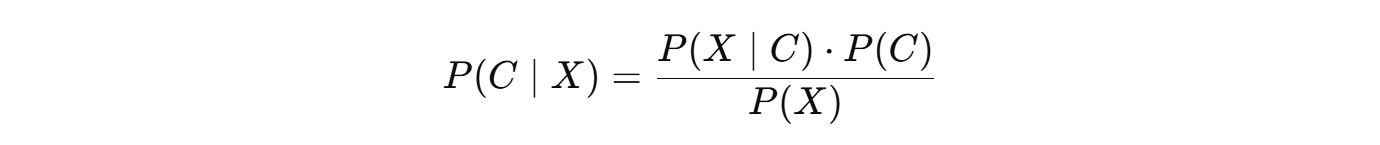

This formula helps us calculate the posterior probability,

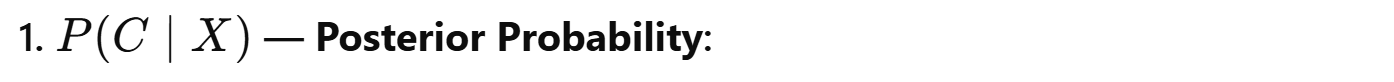

P(C∣X), which is the probability of a class 𝐶 (e.g., spam or not spam) given some observed data

𝑋 (e.g., the contents of an email). Let's break down each component:

1.
𝑃
(
𝐶
∣
𝑋
)
#P(C∣X) — Posterior Probability:
This is what we are trying to find: the probability of the class 𝐶 (e.g., "spam" or "not spam") after seeing the data
𝑋 (e.g., the words in an email).

Think of it like this:

Imagine you're trying to determine whether an email is spam. Based on the contents of the email (the data), what is the likelihood that it's spam?

If the email contains words like "free" and "prize," you might think it's more likely to be spam, so the posterior probability of it being spam increases after seeing those words.

In short,
$$𝑃(𝐶∣𝑋)$$

P(C∣X) tells you how much you should believe that the email belongs to class

𝐶(e.g., "spam") after considering the evidence (data)
𝑋.

---------------------------------------
#2. 𝑃(𝑋∣𝐶) — Likelihood:
This is the probability of the observed data given that you already know the class.

In our example:

$$𝑃(𝑋∣𝐶=spam)##

##P(X∣C=spam) means:
"If we assume the email is spam, how likely is it that this specific set of words

𝑋 (e.g., 'free', 'prize', etc.) would appear in a spam email?"

In other words, the likelihood measures how well a certain class C explains the observed data 𝑋

##For example:

If certain words frequently appear in spam emails, the likelihood of observing those words, given that the email is spam, is high.

-----------------------------------
#Putting It Together:
Let's use an intuitive scenario:

Imagine you get an email that says: "Congratulations! You won a free prize!"

You want to know whether this email is spam or not spam.

That's your 𝐶, the class you're trying to predict.

To calculate this, you use Bayes' Theorem:

##P(C∣X)
is the probability the email is spam after seeing the words "Congratulations!" and "free prize." (This is what we want to know!)

##P(X∣C)
tells you how likely it is that a spam email contains words like "Congratulations!" and "free prize."

If spam emails often have these words, P(X∣C=spam) will be high.

Finally, based on how common spam is overall and how well these words match typical spam content, Bayes' Theorem combines these probabilities to give you a posterior probability P(C∣X) — how likely it is that this particular email is spam.

----------------------------
#Summary

##P(C∣X) (Posterior Probability):

After seeing the data (like words in an email), how likely is it that the email is spam?

##P(X∣C) (Likelihood):
If the email is spam, how likely are we to see this specific set of words?

This process allows us to update our beliefs about whether the email is spam based on the evidence we observe (the words in the email).

-------------------------------
#Understanding the Reversal with an Analogy:
Imagine you’re a doctor diagnosing a patient for a rare disease, and the patient has just received a positive test result.

You want to figure out how likely it is that they actually have the disease.

Now, you have two different ways of thinking:

Likelihood: If the patient has the disease (this is
𝐶, the class), how likely is it that they would test positive (this is 𝑋, the evidence)?

Example: If the disease causes a positive test 90% of the time, then
    P(X∣C)=0.90.
Posterior Probability: Given that the patient tested positive (this is 𝑋, the data), how likely is it that they actually have the disease (this is 𝐶)?

This is what you’re really interested in:

P(C∣X), the probability they have the disease

## Run predictions and analyze the results (naïve Bayes)

In [24]:
# Form a prediction set
predictions = text_clf_nb.predict(X_test)

In [25]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[287  21]
 [130 202]]


In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         neg       0.69      0.93      0.79       308
         pos       0.91      0.61      0.73       332

   micro avg       0.76      0.76      0.76       640
   macro avg       0.80      0.77      0.76       640
weighted avg       0.80      0.76      0.76       640



In [ ]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.7640625


Naïve Bayes gave us better-than-average results at 76.4% for classifying reviews as positive or negative based on text alone. Let's see if we can do better.

## Feed the training data through the second pipeline
Next we'll run Linear SVC

In [ ]:
text_clf_lsvc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

## Run predictions and analyze the results (Linear SVC)

In [ ]:
# Form a prediction set
predictions = text_clf_lsvc.predict(X_test)

In [ ]:
# Report the confusion matrix
from sklearn import metrics
print(metrics.confusion_matrix(y_test,predictions))

[[259  49]
 [ 49 283]]


In [ ]:
# Print a classification report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         neg       0.84      0.84      0.84       308
         pos       0.85      0.85      0.85       332

   micro avg       0.85      0.85      0.85       640
   macro avg       0.85      0.85      0.85       640
weighted avg       0.85      0.85      0.85       640



In [ ]:
# Print the overall accuracy
print(metrics.accuracy_score(y_test,predictions))

0.846875


Not bad! Based on text alone we correctly classified reviews as positive or negative **84.7%** of the time. In an upcoming section we'll try to improve this score even further by performing *sentiment analysis* on the reviews.

## Advanced Topic - Adding Stopwords to CountVectorizer
By default, **CountVectorizer** and **TfidfVectorizer** do *not* filter stopwords. However, they offer some optional settings, including passing in your own stopword list.
<div class="alert alert-info" style="margin: 20px">CAUTION: There are some [known issues](http://aclweb.org/anthology/W18-2502) using Scikit-learn's built-in stopwords list. Some words that are filtered may in fact aid in classification. In this section we'll pass in our own stopword list, so that we know exactly what's being filtered.</div>

The [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class accepts the following arguments:
> *CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, **stop_words=None**, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)*

[TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) supports the same arguments and more. Under *stop_words* we have the following options:
> stop_words : *string {'english'}, list, or None (default)*

That is, we can run `TfidVectorizer(stop_words='english')` to accept scikit-learn's built-in list,<br>
or `TfidVectorizer(stop_words=[a, and, the])` to filter these three words. In practice we would assign our list to a variable and pass that in instead.

Scikit-learn's built-in list contains 318 stopwords:
> <pre>from sklearn.feature_extraction import text
> print(text.ENGLISH_STOP_WORDS)</pre>
['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'another', 'any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere', 'are', 'around', 'as', 'at', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'between', 'beyond', 'bill', 'both', 'bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant', 'co', 'con', 'could', 'couldnt', 'cry', 'de', 'describe', 'detail', 'do', 'done', 'down', 'due', 'during', 'each', 'eg', 'eight', 'either', 'eleven', 'else', 'elsewhere', 'empty', 'enough', 'etc', 'even', 'ever', 'every', 'everyone', 'everything', 'everywhere', 'except', 'few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first', 'five', 'for', 'former', 'formerly', 'forty', 'found', 'four', 'from', 'front', 'full', 'further', 'get', 'give', 'go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'however', 'hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed', 'interest', 'into', 'is', 'it', 'its', 'itself', 'keep', 'last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made', 'many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine', 'more', 'moreover', 'most', 'mostly', 'move', 'much', 'must', 'my', 'myself', 'name', 'namely', 'neither', 'never', 'nevertheless', 'next', 'nine', 'no', 'nobody', 'none', 'noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of', 'off', 'often', 'on', 'once', 'one', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'part', 'per', 'perhaps', 'please', 'put', 'rather', 're', 'same', 'see', 'seem', 'seemed', 'seeming', 'seems', 'serious', 'several', 'she', 'should', 'show', 'side', 'since', 'sincere', 'six', 'sixty', 'so', 'some', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhere', 'still', 'such', 'system', 'take', 'ten', 'than', 'that', 'the', 'their', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'thereupon', 'these', 'they', 'thick', 'thin', 'third', 'this', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'top', 'toward', 'towards', 'twelve', 'twenty', 'two', 'un', 'under', 'until', 'up', 'upon', 'us', 'very', 'via', 'was', 'we', 'well', 'were', 'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with', 'within', 'without', 'would', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves']

However, there are words in this list that may influence a classification of movie reviews. With this in mind, let's trim the list to just 60 words:

In [ ]:
stopwords = ['a', 'about', 'an', 'and', 'are', 'as', 'at', 'be', 'been', 'but', 'by', 'can', \
             'even', 'ever', 'for', 'from', 'get', 'had', 'has', 'have', 'he', 'her', 'hers', 'his', \
             'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'me', 'my', 'of', 'on', 'or', \
             'see', 'seen', 'she', 'so', 'than', 'that', 'the', 'their', 'there', 'they', 'this', \
             'to', 'was', 'we', 'were', 'what', 'when', 'which', 'who', 'will', 'with', 'you']

Now let's repeat the process above and see if the removal of stopwords improves or impairs our score.

In [ ]:
# YOU DO NOT NEED TO RUN THIS CELL UNLESS YOU HAVE
# RECENTLY OPENED THIS NOTEBOOK OR RESTARTED THE KERNEL:

import numpy as np
import pandas as pd

df = pd.read_csv('../TextFiles/moviereviews.tsv', sep='\t')
df.dropna(inplace=True)
blanks = []
for i,lb,rv in df.itertuples():
    if type(rv)==str:
        if rv.isspace():
            blanks.append(i)
df.drop(blanks, inplace=True)
from sklearn.model_selection import train_test_split
X = df['review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

In [ ]:
# RUN THIS CELL TO ADD STOPWORDS TO THE LINEAR SVC PIPELINE:
text_clf_lsvc2 = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('clf', LinearSVC()),
])
text_clf_lsvc2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [ ]:
predictions = text_clf_lsvc2.predict(X_test)
print(metrics.confusion_matrix(y_test,predictions))

[[256  52]
 [ 48 284]]


In [ ]:
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

         neg       0.84      0.83      0.84       308
         pos       0.85      0.86      0.85       332

   micro avg       0.84      0.84      0.84       640
   macro avg       0.84      0.84      0.84       640
weighted avg       0.84      0.84      0.84       640



In [ ]:
print(metrics.accuracy_score(y_test,predictions))

0.84375


Our score didn't change that much. We went from 84.7% without filtering stopwords to 84.4% after adding a stopword filter to our pipeline. Keep in mind that 2000 movie reviews is a relatively small dataset. The real gain from stripping stopwords is improved processing speed; depending on the size of the corpus, it might save hours.

## Feed new data into a trained model
Once we've developed a fairly accurate model, it's time to feed new data through it. In this last section we'll write our own review, and see how accurately our model assigns a "positive" or "negative" label to it.

### First, train the model

In [ ]:
# YOU DO NOT NEED TO RUN THIS CELL UNLESS YOU HAVE
# RECENTLY OPENED THIS NOTEBOOK OR RESTARTED THE KERNEL:

import numpy as np
import pandas as pd

df = pd.read_csv('../TextFiles/moviereviews.tsv', sep='\t')
df.dropna(inplace=True)
blanks = []
for i,lb,rv in df.itertuples():
    if type(rv)==str:
        if rv.isspace():
            blanks.append(i)
df.drop(blanks, inplace=True)
from sklearn.model_selection import train_test_split
X = df['review']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

# Naïve Bayes Model:
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB()),
])

# Linear SVC Model:
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

# Train both models on the moviereviews.tsv training set:
text_clf_nb.fit(X_train, y_train)
text_clf_lsvc.fit(X_train, y_train)

### Next, feed new data to the model's `predict()` method

In [ ]:
myreview = "A movie I really wanted to love was terrible. \
I'm sure the producers had the best intentions, but the execution was lacking."

In [ ]:
# Use this space to write your own review. Experiment with different lengths and writing styles.
myreview =






In [ ]:
print(text_clf_nb.predict([myreview]))  # be sure to put "myreview" inside square brackets

['neg']


In [ ]:
print(text_clf_lsvc.predict([myreview]))

['neg']


Great! Now you should be able to build text classification pipelines in scikit-learn, apply a variety of algorithms like naïve Bayes and Linear SVC, handle stopwords, and test a fitted model on new data.

## Up next: Text Classification Assessment